In [1]:
# nuclio: ignore
import nuclio

In [2]:
%nuclio config kind = "job"
%nuclio config spec.image = "yjbds/ml-models:0.4.8"

%nuclio: setting kind to 'job'
%nuclio: setting spec.image to 'yjbds/ml-models:0.4.8'


In [3]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [21]:
import os
import pandas as pd
from mlrun.datastore import DataItem
from mlrun.artifacts import get_model
from mlutils import eval_class_model
from cloudpickle import load
from urllib.request import urlopen

def test_classifier(
    context,
    models_path: DataItem, 
    test_set: DataItem,
    label_column: str,
    score_method: str = 'micro',
    plots_dest: str = "",
    model_evaluator = None,
    default_model: str = "model.pkl"
) -> None:
    """Test one or more classifier models against held-out dataset
    
    Using held-out test features, evaluates the peformance of the estimated model
    
    Can be part of a kubeflow pipeline as a test step that is run post EDA and 
    training/validation cycles
    
    :param context:         the function context
    :param models_path:     artifact models representing a file or a folder
    :param test_set:        test features and labels
    :param label_column:    column name for ground truth labels
    :param score_method:    for multiclass classification
    :param plots_dest:      dir for test plots
    :param model_evaluator: NOT IMPLEMENTED: specific method to generate eval, passed in as string
                            or available in this folder
    """
    xtest = test_set.as_df()
    ytest = xtest.pop(label_column)
    
    try:
        model_file, model_obj, _ = get_model(models_path.url, suffix='.pkl')
        model_obj = load(open(model_file, "rb"))
    except ValueError as va: 
        model_file = os.path.join(str(models_path), default_model)
        model_obj = load(urlopen(model_file))
    except Exception as a:
        raise Exception("model location likely specified")
    
    eval_metrics = eval_class_model(context, xtest, ytest.values, model_obj)

    # just do this inside log_model?
    model_plots = eval_metrics.pop("plots")
    for plot in model_plots:
        context.log_artifact(plot, local_path=f"{plots_dest}/{plot.key}.html")
    
    if hasattr(eval_metrics, "tables"):
        model_tables = eval_metrics.pop("tables")
        for tbl in model_tables:
            context.log_artifact(tbl, local_path=f"{plots_dest}/{plot.key}.csv")

    context.log_results(eval_metrics)
    
    # get y_hat:
    y_hat = model_obj.predict(xtest)
    # give the prediction columns titles/headers
    if y_hat.ndim == 1 or y_hat.shape[1] == 1:
        score_names = ["yscore"]
    else:
        score_names = ["yscore_" + str(x) for x in range(y_hat.shape[1])]

    # log the test set and its predictions (should also bind model and metadata)
    df = pd.concat([xtest, ytest, pd.DataFrame(y_hat, columns=score_names)], axis=1)
    context.log_dataset("test_set_preds", df=df, format="parquet", index=False)

In [22]:
# nuclio: end-code

### mlconfig

In [23]:
from mlrun import mlconf
import os

mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'
mlconf.artifact_path = mlconf.artifact_path or f'{os.environ["HOME"]}/artifacts'

### save

In [24]:
from mlrun import code_to_function 
# create job function object from notebook code
fn = code_to_function("test_classifier")

# add metadata (for templates and reuse)
fn.spec.default_handler = "test_classifier"
fn.spec.description = "test a classifier using held-out or new data"
fn.metadata.categories = ["ml", "test"]
fn.metadata.labels = {"author": "yjb", "framework": "sklearn"}
fn.export("function.yaml")

[mlrun] 2020-05-26 23:52:02,379 function spec saved to path: function.yaml


## tests

In [25]:
from mlutils import get_vol_mount
fn.apply(get_vol_mount())

In [26]:
task_params = {
    "name" : "tasks test classifier",
    "params": {
        "label_column"  : "label",
        "plots_dest"    : "sklearn_classifier/plots"}}

### run locally

In [30]:
TEST_REPO = "https://raw.githubusercontent.com/yjb-ds/testdata/master"
DATA_PATH  = "models/test_classifier/test_set.csv"
MODELS_PATH = "models/test_classifier/model.pkl"

[mlrun] 2020-05-27 00:38:25,822 starting run tasks test classifier uid=1f48fec458774425a20c3a4c685083dc  -> http://mlrun-api:8080
MULTICLASS True
[mlrun] 2020-05-27 00:38:26,388 log artifact confusion-matrix-normalized at /User/artifacts/test-classifier/sklearn_classifier/plots/confusion-matrix-normalized.html, size: 14138, db: Y
[mlrun] 2020-05-27 00:38:26,410 log artifact precision-recall-multiclass at /User/artifacts/test-classifier/sklearn_classifier/plots/precision-recall-multiclass.html, size: 1766, db: Y
[mlrun] 2020-05-27 00:38:26,491 log artifact roc-multiclass at /User/artifacts/test-classifier/sklearn_classifier/plots/roc-multiclass.html, size: 20865, db: Y
[mlrun] 2020-05-27 00:38:26,584 log artifact test_set_preds at /User/artifacts/test-classifier/test_set_preds.parquet, size: 5179, db: Y



project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...685083dc,0,May 27 00:38:25,completed,tasks test classifier,v3io_user=adminkind=handlerowner=adminhost=jupyter-f9d6597fd-ns9cj,test_setmodels_path,label_column=labelplots_dest=sklearn_classifier/plots,test-accuracy=0.9111111111111111test-error=0.08888888888888889auc-micro=0.9930864197530864auc-weighted=0.9886831275720165f1-score=0.9237472766884531precision_score=0.9237472766884531recall_score=0.9237472766884531tables=[],confusion-matrix-normalizedprecision-recall-multiclassroc-multiclasstest_set_preds


to track results use .show() or .logs() or in CLI: 
!mlrun get run 1f48fec458774425a20c3a4c685083dc --project default , !mlrun logs 1f48fec458774425a20c3a4c685083dc --project default
[mlrun] 2020-05-27 00:38:26,638 run executed, status=completed


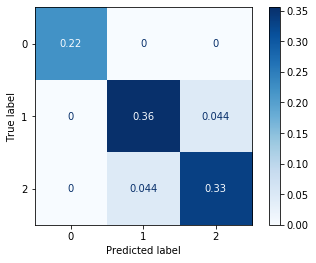

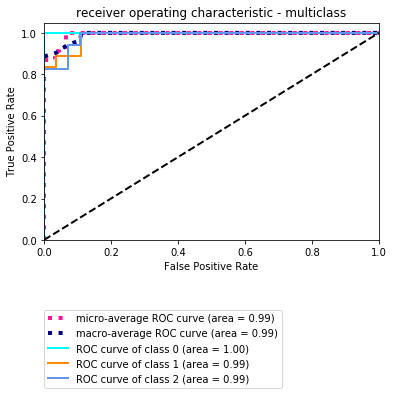

In [31]:
from mlrun import run_local, NewTask

run = run_local(NewTask(**task_params),
                handler=test_classifier,
                inputs={"test_set":   f"{TEST_REPO}/{DATA_PATH}",
                        "models_path": f"{TEST_REPO}/{MODELS_PATH}"},
                artifact_path=mlconf.artifact_path + "/test-classifier")

### remotely

In [33]:
from mlrun import NewTask
run = fn.run(NewTask(**task_params), 
             inputs={"test_set":   f"{TEST_REPO}/{DATA_PATH}",
                     "models_path": f"{TEST_REPO}/{MODELS_PATH}"},
             artifact_path=mlconf.artifact_path + "/test-classifier")

[mlrun] 2020-05-27 00:39:16,934 starting run tasks test classifier uid=131466f59bc54059b82762c23200e8a5  -> http://mlrun-api:8080
[mlrun] 2020-05-27 00:39:17,035 Job is running in the background, pod: tasks-test-classifier-mfvsn
[mlrun] 2020-05-27 00:39:20,535 starting local run: main.py # test_classifier
MULTICLASS True
[mlrun] 2020-05-27 00:39:21,720 log artifact confusion-matrix-normalized at /User/artifacts/test-classifier/sklearn_classifier/plots/confusion-matrix-normalized.html, size: 26234, db: Y
[mlrun] 2020-05-27 00:39:21,751 log artifact precision-recall-multiclass at /User/artifacts/test-classifier/sklearn_classifier/plots/precision-recall-multiclass.html, size: 3286, db: Y
[mlrun] 2020-05-27 00:39:21,830 log artifact roc-multiclass at /User/artifacts/test-classifier/sklearn_classifier/plots/roc-multiclass.html, size: 41457, db: Y
[mlrun] 2020-05-27 00:39:21,919 log artifact test_set_preds at /User/artifacts/test-classifier/test_set_preds.parquet, size: 5371, db: Y

[mlrun] 

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...3200e8a5,0,May 27 00:39:21,completed,tasks test classifier,v3io_user=adminkind=jobowner=adminhost=tasks-test-classifier-mfvsn,test_setmodels_path,label_column=labelplots_dest=sklearn_classifier/plots,test-accuracy=0.9111111111111111test-error=0.08888888888888889auc-micro=0.9930864197530864auc-weighted=0.9886831275720165f1-score=0.9237472766884531precision_score=0.9237472766884531recall_score=0.9237472766884531tables=[],confusion-matrix-normalizedprecision-recall-multiclassroc-multiclasstest_set_preds


to track results use .show() or .logs() or in CLI: 
!mlrun get run 131466f59bc54059b82762c23200e8a5  , !mlrun logs 131466f59bc54059b82762c23200e8a5 
[mlrun] 2020-05-27 00:39:26,307 run executed, status=completed
